In [23]:
from random import randint
from pandas import Timestamp, Timedelta
from scipy.fft import fft
from matplotlib import pyplot as plt

import numpy as np
import scipy.signal as sg
def autocorrelation(arr:np.ndarray) -> np.ndarray:
    ret = arr-np.mean(arr)
    ret = sg.correlate(ret,ret,mode="full")[len(ret)-1:]
    # Required overlap of at least 33% of the data
    return ret[:2*len(ret)//3] / ret[0]

In [24]:
f = open("covid_confirmed_usafacts.csv","r")

headers = next(f).split(",")

for i in range(4,len(headers)):
    tmp = tuple(map(lambda x : int(x),headers[i].split("/")))

    headers[i] = Timestamp(year=2000+tmp[2], month=tmp[0], day=tmp[1])

lines = []

for line in f:
    tmp = line.rstrip().split(",")
    #print(tmp[4:])
    # Calc delta
    for i in range(len(tmp)-1,4,-1):
        tmp[i-1] = int(tmp[i-1])
        tmp[i] = int(tmp[i]) - tmp[i-1]
    # Correct missing data
    for i in range(len(tmp)-1,5,-1):
        if tmp[i] > 0 and tmp[i-1] == 0 and tmp[i-2] > 0:
            tmp[i] /= 2
            tmp[i-1] = tmp[i]
    # Calculate relative delta
    for i in range(len(tmp)-1,4,-1):
        if tmp[i-1] >= 30:
            tmp[i] = tmp[i] / tmp[i-1]
    #print(tmp[4:],"\n")
    lines.append([tmp[:4],tmp[4:]])

f.close()

In [25]:
validPeriods = []

for line in lines:
    lineData = line[1]
    periods = []
    inPeriod = False
    minI = 0
    
    # Look for consecutive dates (> 14 days) with more than 20 cases per day
    for i,inc in enumerate(lineData):
        if type(inc) is int:
            if inPeriod:
                if i - minI >= 14:
                    periods.append((minI,i))
                inPeriod = False
            else:
                minI = i
        elif not inPeriod:
            inPeriod = True
            minI = i

    # Gather period data, with location, dates,
    # relative deltas and autocorrelation of relative deltas
    for period in periods:
        newPeriod = [line[0],headers[period[0]:period[1]]]
        tmp = np.array(line[1][period[0]:period[1]])
        newPeriod.append(tmp)
        newPeriod.append(autocorrelation(tmp))

        validPeriods.append(tuple(newPeriod))
        #print(newPeriod)
        
#validPeriods

In [26]:
minLen = 15

transformInfo = []
transforms = []

# Look for autocorrelations for periods of at least 3 weeks
for validPeriod in validPeriods:
    if len(validPeriod[3]) >= minLen:
        transforms.append(validPeriod[3][:minLen])

transforms = np.array(transforms)

len(transforms)

248

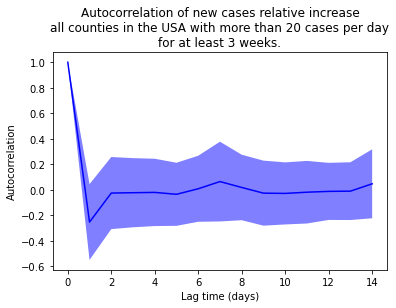

In [27]:
fig,ax = plt.subplots()

transform_means = np.mean(transforms,axis=0)
transform_sd = np.std(transforms,axis=0)

#tmp = np.abs(transforms)
#transform_abs_means = np.mean(tmp,axis=0)
#transform_abs_sd = np.std(tmp,axis=0)

ax.plot(range(15),transform_means,color="blue")
#ax.plot(range(15),transform_abs_means,color="orange")

ax.fill_between(range(15), transform_means+1.96*transform_sd, transform_means-1.96*transform_sd, facecolor='blue', alpha=0.5)
#ax.fill_between(range(15), transform_abs_means+1.96*transform_abs_sd, transform_abs_means-1.96*transform_abs_sd, facecolor='orange', alpha=0.5)

ax.set_xlabel("Lag time (days)")
ax.set_ylabel("Autocorrelation")

ax.set_title("Autocorrelation of new cases relative increase\nall counties in the USA with more than 20 cases per day\nfor at least 3 weeks.")

plt.show()